In [1]:
import cv2
import numpy as np 
import glob
import os
import matplotlib.pyplot as plt


In [2]:
img_folder="./calibration_images/"
img_list=[]
image_paths = sorted(glob.glob(os.path.join(img_folder, "*.JPEG")), key=lambda x: os.path.basename(x).split('.')[0])
print("Image Paths: ", len(image_paths) ,image_paths,)
cali_images = [cv2.imread(image_path) for image_path in image_paths]


Image Paths:  8 ['./calibration_images/IMG_3910.JPEG', './calibration_images/IMG_3913.JPEG', './calibration_images/IMG_3914.JPEG', './calibration_images/IMG_3915.JPEG', './calibration_images/IMG_3916.JPEG', './calibration_images/IMG_3917.JPEG', './calibration_images/IMG_3918.JPEG', './calibration_images/IMG_3919.JPEG']


In [3]:
def show_images(images):
    for img in cali_images:
        plt.imshow(img)
        print(img.shape)
        plt.show()


(1920, 1080, 3)


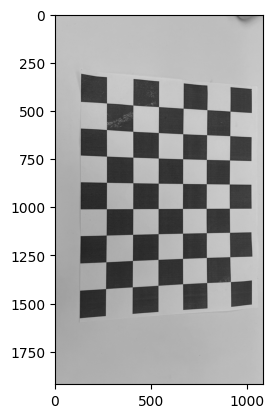

(1920, 1080, 3)


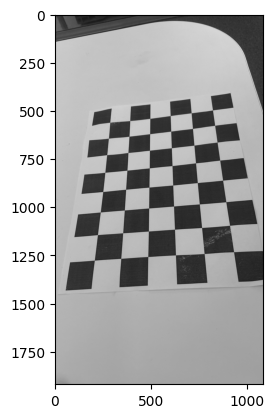

(1920, 1080, 3)


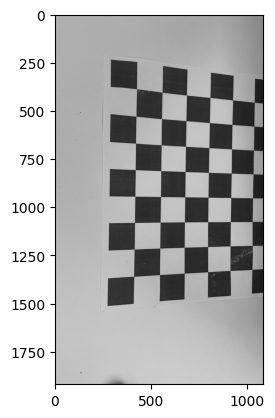

(1920, 1080, 3)


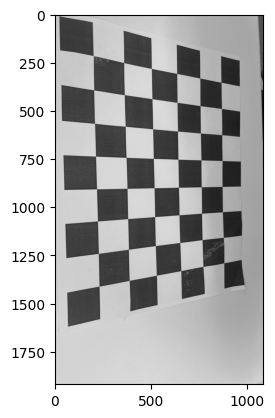

(1920, 1080, 3)


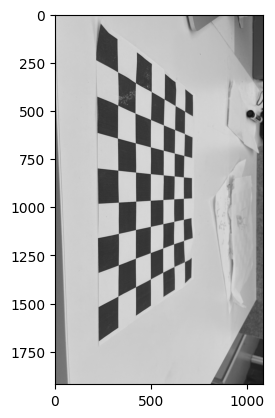

(1920, 1080, 3)


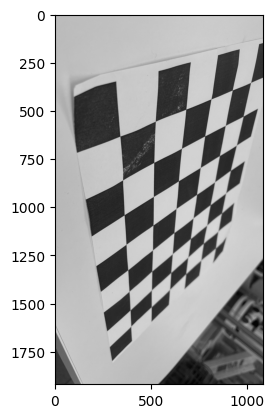

(1920, 1080, 3)


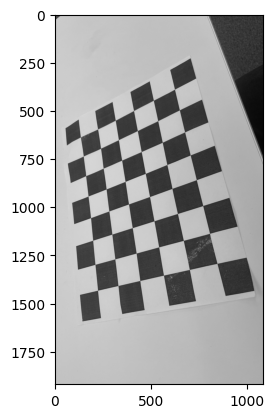

(1920, 1080, 3)


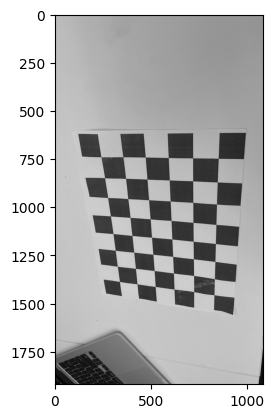

In [4]:
show_images(cali_images)

In [5]:
def find_ChessboardCorners(imgs,chessboard_pattern=(6,8)):
    chessboard_corners=[]
    ret_li=[]
    for img in imgs:
        #gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray_image=img[...,0]
        
        ret, corners = cv2.findChessboardCorners(gray_image, chessboard_pattern,cv2.CALIB_CB_NORMALIZE_IMAGE  )
        
        if ret:
            corners = cv2.cornerSubPix(
                gray_image, corners, (5, 5), (-1, -1),
                criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            )
            chessboard_corners.append(corners)
            ret_li.append(ret)
        else:
            chessboard_corners.append([])
            ret_li.append(ret)
            
    return ret_li,chessboard_corners
    


In [6]:
ret,corners=find_ChessboardCorners(cali_images)
print(ret)
#print(corners)

[True, True, True, True, True, False, True, True]


In [7]:
def display_corners(ret,corners,images,chessboard_pattern=(6,8)):
    for itr in range(len(images)):
        if ret[itr]:
            cv2.drawChessboardCorners(images[itr], chessboard_pattern, corners[itr], ret[itr])
        plt.imshow(images[itr])  
        plt.show()   

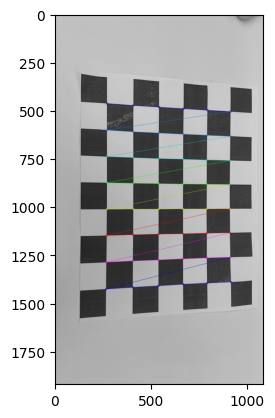

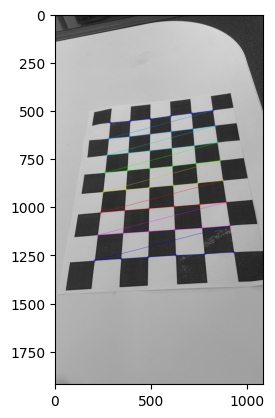

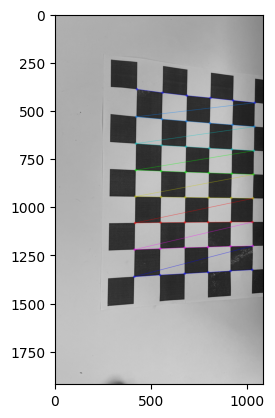

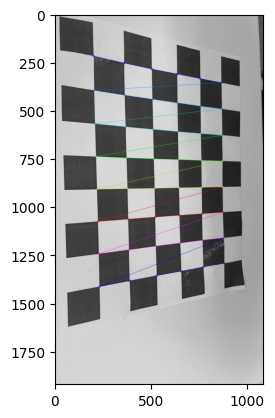

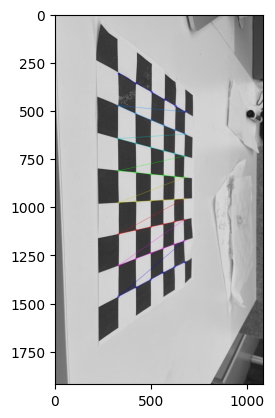

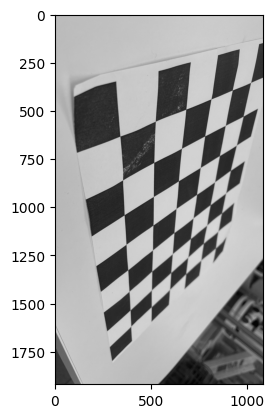

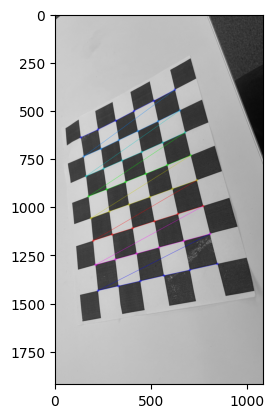

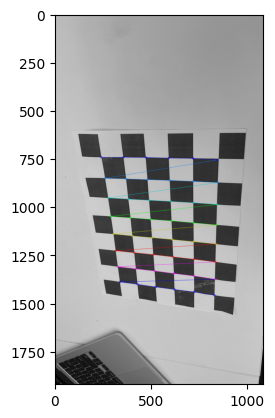

In [8]:
display_corners(ret=ret,corners=corners,images=cali_images)

In [9]:
chessboard_pattern=[6,8]
square_size=0.01

In [10]:
def remove_undeteched_data(imgs,corners,ret):
    new_imgs=[]
    new_corners=[]
    new_ret=[]
    for itr,detected in enumerate(ret):
        if detected:
           new_corners.append(corners[itr])
           new_imgs.append(imgs[itr])
           new_ret.append(detected)
           
    return new_ret,new_corners,new_imgs 

In [11]:
clean_ret,clean_corners,clean_imgs=remove_undeteched_data(ret=ret,corners=corners,imgs=cali_images)

In [12]:
object_points = np.zeros((chessboard_pattern[0] * chessboard_pattern[1], 3), np.float32)
object_points[:, :2] = np.mgrid[0:chessboard_pattern[0], 0:chessboard_pattern[1]].T.reshape(-1, 2)
object_points *= square_size 
#print(object_points)

In [13]:
all_object_points=[]

for imgs in clean_imgs:
    all_object_points.append(object_points)
print(len(all_object_points),all_object_points[0].shape)

7 (48, 3)


In [14]:
#Ques 1 answer
imgs_shape=clean_imgs[0].shape[:2][::-1]
ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
    all_object_points, clean_corners,imgs_shape, None, None
)

# Display calibration results
print("Camera Matrix:\n", camera_matrix)
print("\nDistortion Coefficients:\n", dist_coeffs)
#print("\nRotation Vectors:\n", rvecs)
#print("\nTranslation Vectors:\n", tvecs)

Camera Matrix:
 [[1.48052617e+03 0.00000000e+00 5.49286333e+02]
 [0.00000000e+00 1.47461046e+03 9.39949089e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients:
 [[ 0.23638885 -1.01460061 -0.00328882  0.0055401   1.52685586]]


In [15]:
# w,h= clean_imgs[0].shape[:2]
# newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w,h), 1, (w,h))

In [16]:
clean_imgs[0].shape[:2]

(1920, 1080)

In [17]:
mean_error = 0
for i in range(len(all_object_points)):
    imgpoints2, _ = cv2.projectPoints(all_object_points[i], rvecs[i], tvecs[i], camera_matrix, dist_coeffs)
    error = cv2.norm(clean_corners[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
 
print( "total Reprojection error: {}".format(mean_error/len(all_object_points)) )

total Reprojection error: 0.1846286842027584


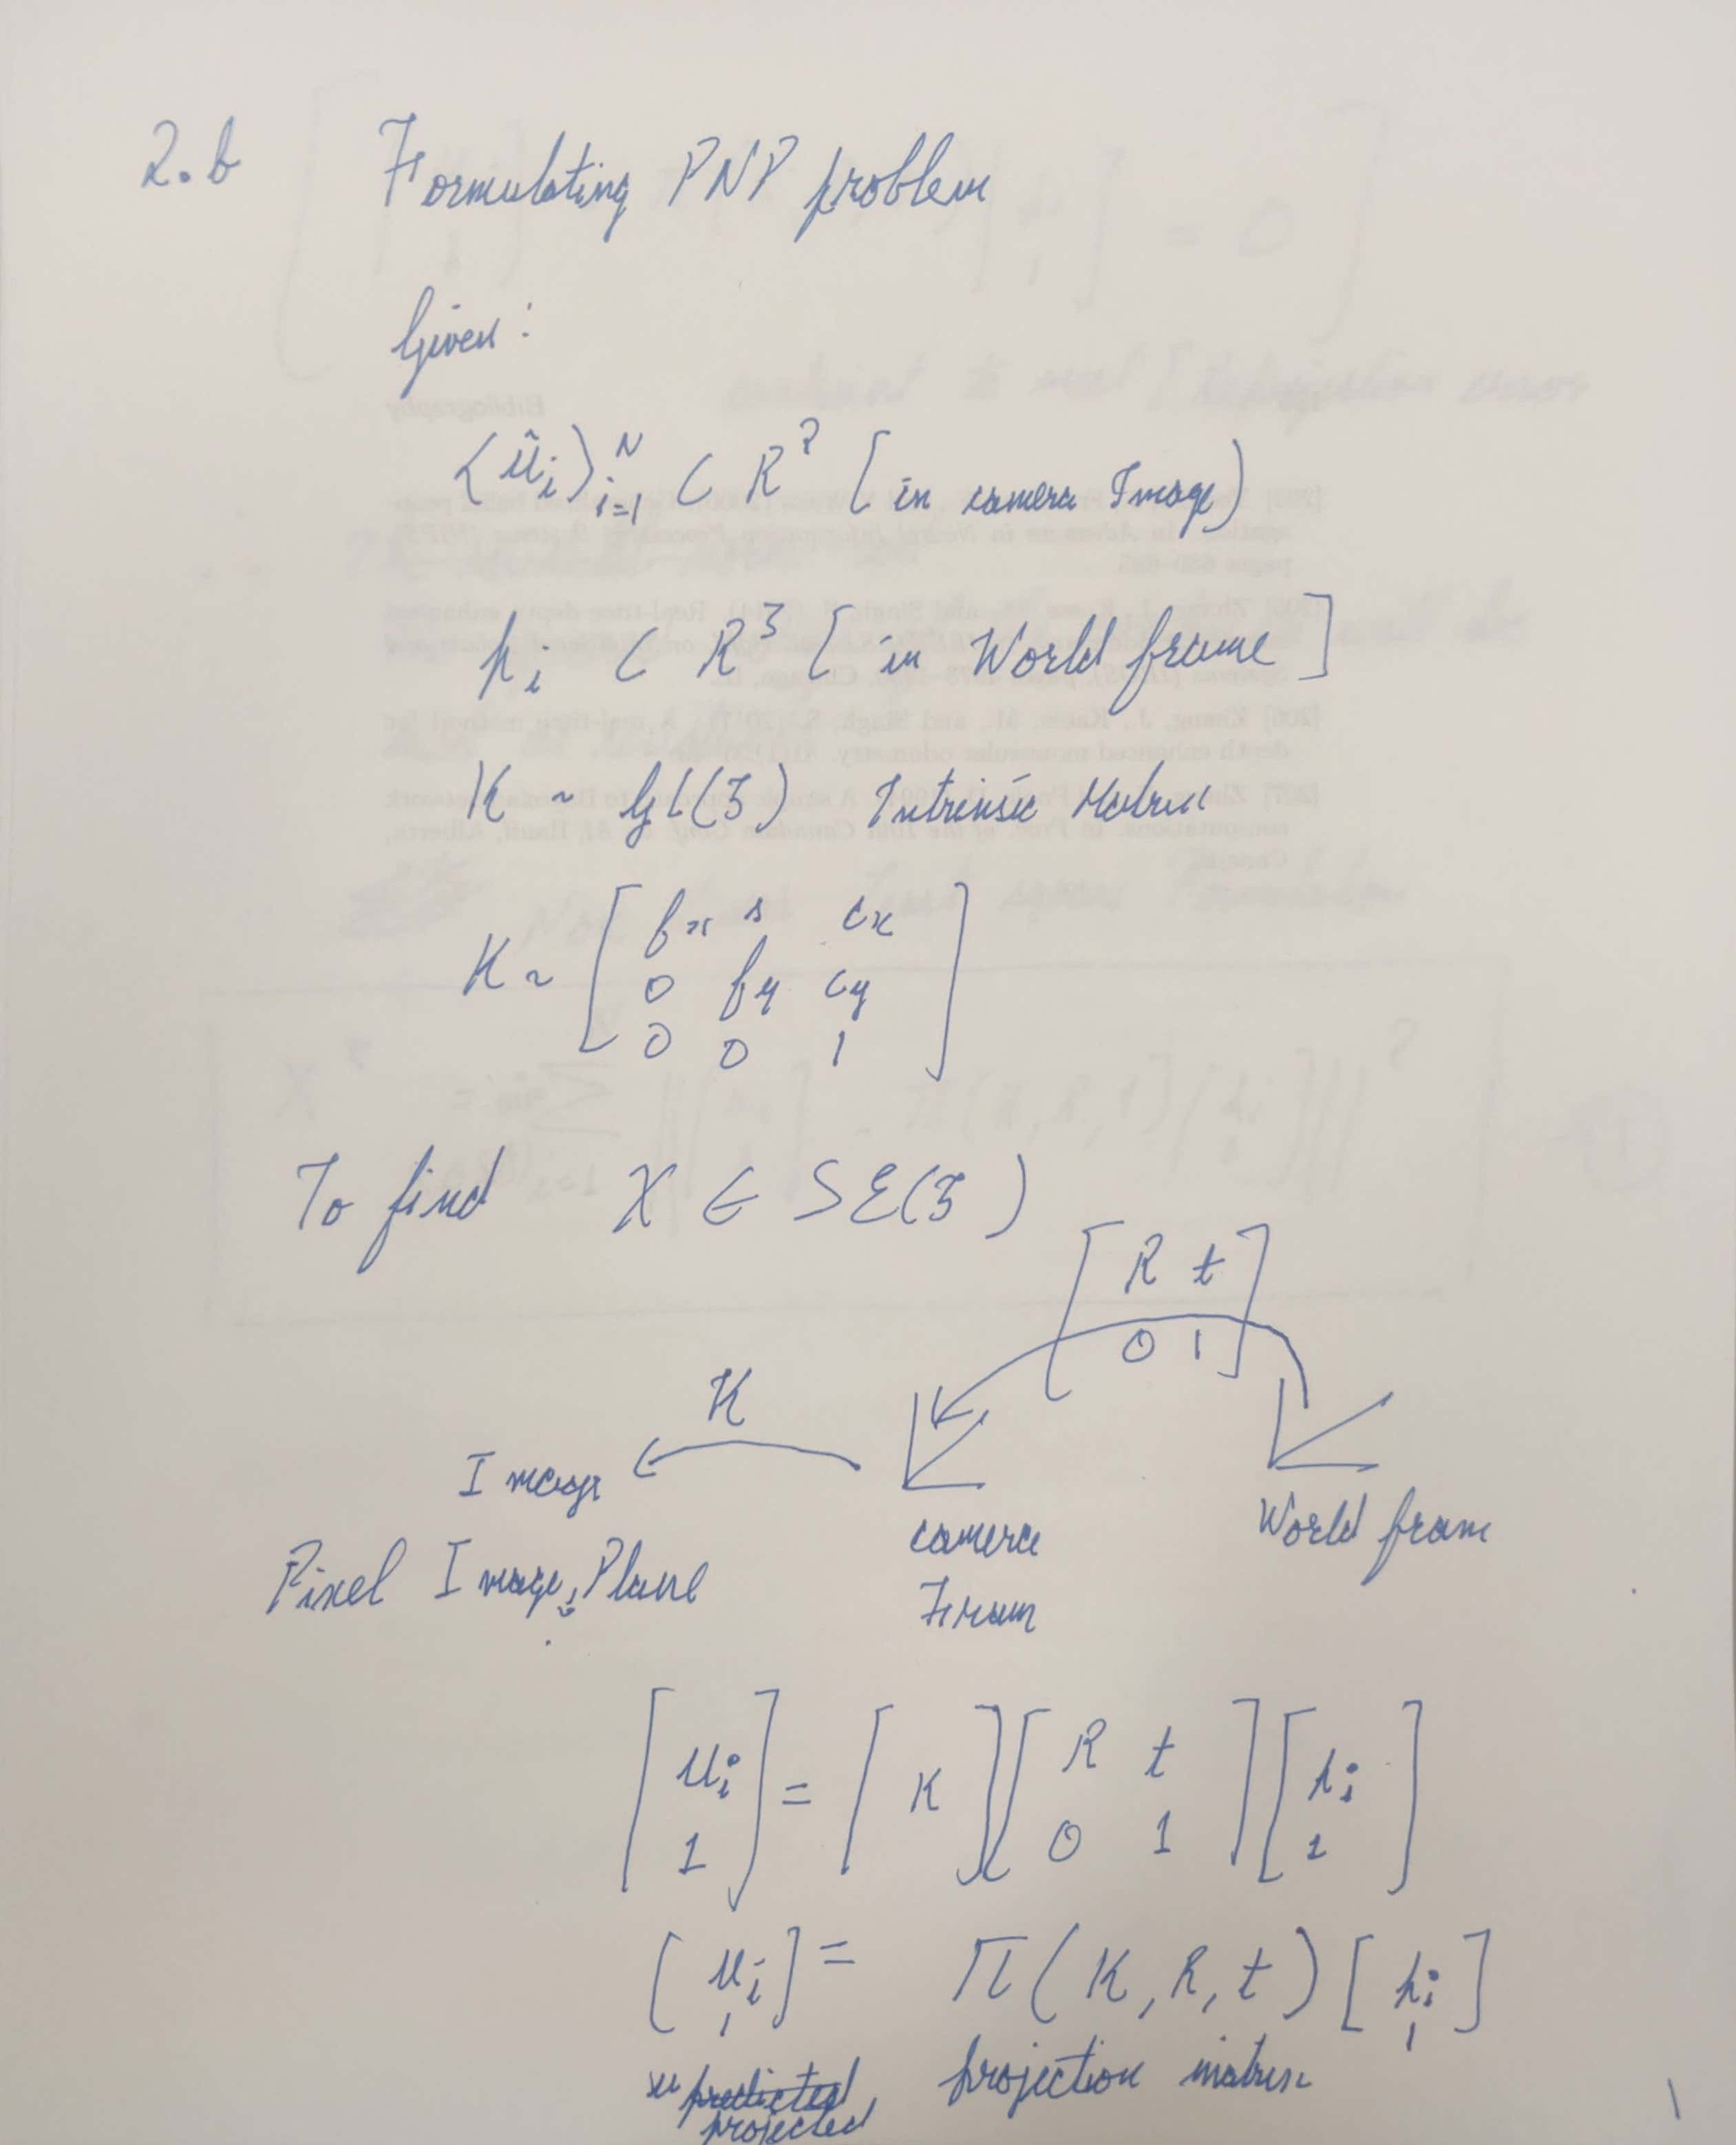

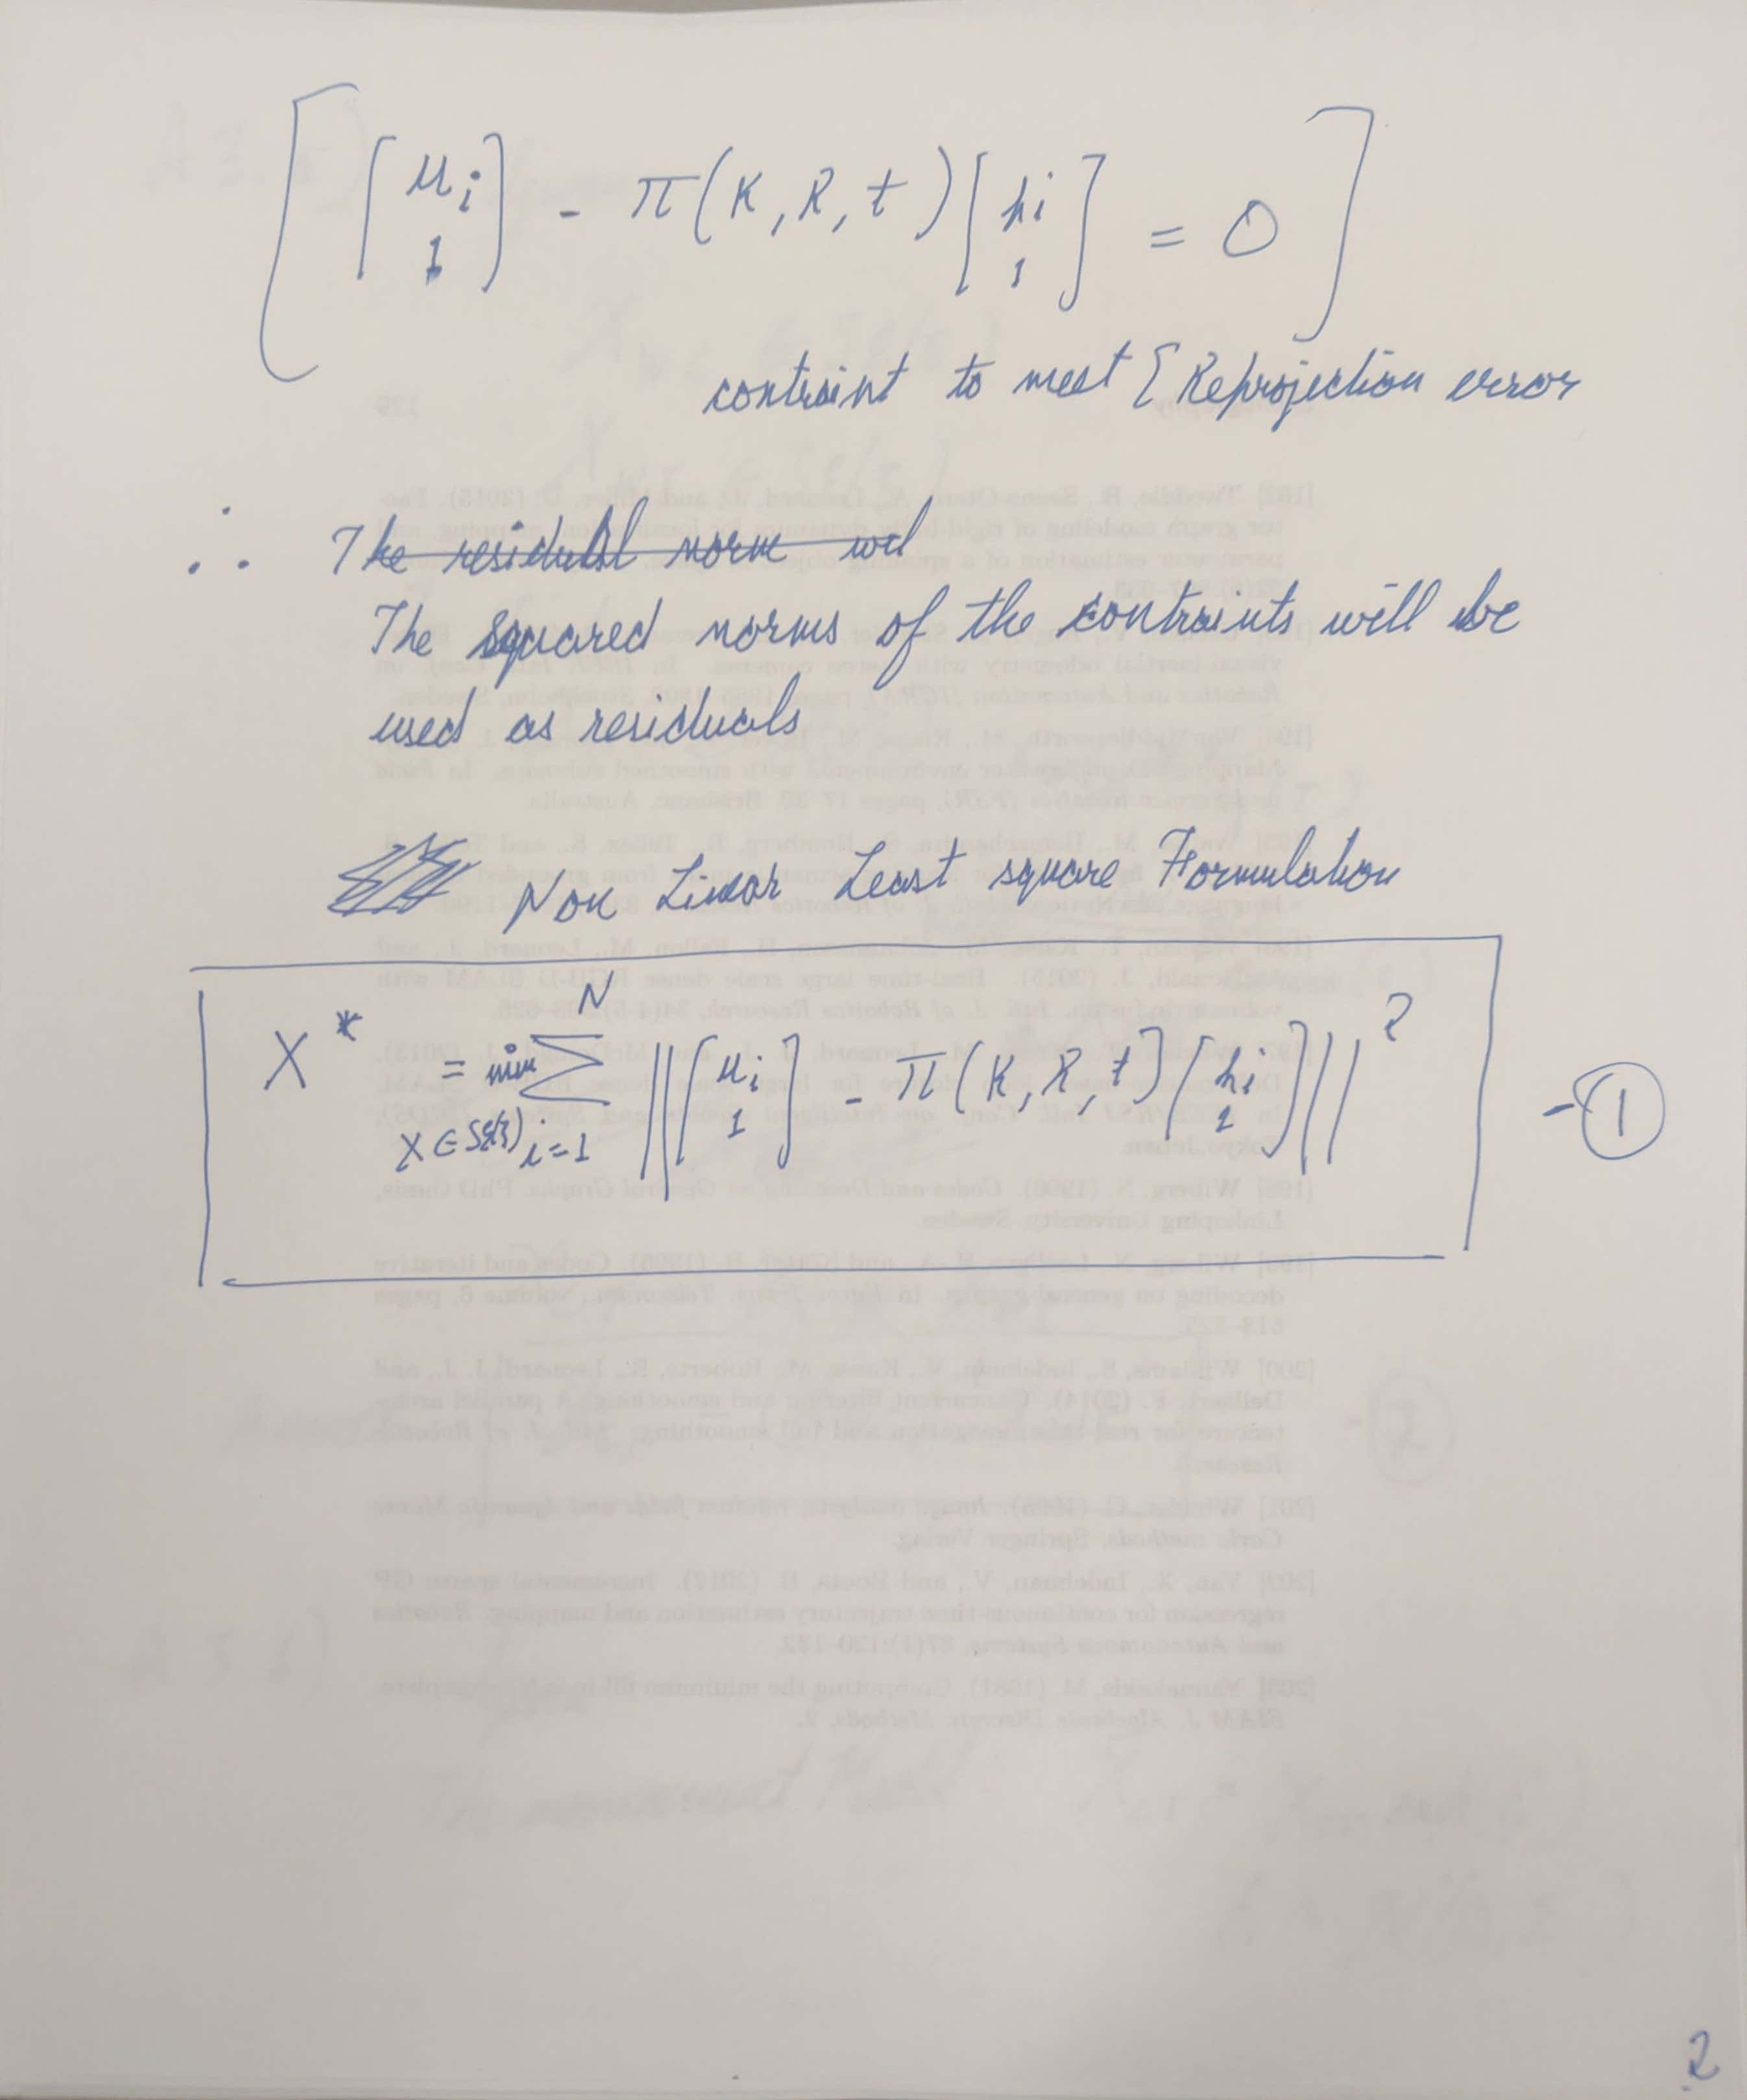

In [18]:
img_folder="./vslam/"
img_list=[]
image_paths = sorted(glob.glob(os.path.join(img_folder, "*.jpg")), key=lambda x: os.path.basename(x).split('.')[0])
print("Image Paths: ", len(image_paths) ,image_paths[:10])
vslam_images = [cv2.imread(image_path) for image_path in image_paths]


Image Paths:  500 ['./vslam/frame_0.jpg', './vslam/frame_1.jpg', './vslam/frame_10.jpg', './vslam/frame_100.jpg', './vslam/frame_101.jpg', './vslam/frame_102.jpg', './vslam/frame_103.jpg', './vslam/frame_104.jpg', './vslam/frame_105.jpg', './vslam/frame_106.jpg']


In [19]:
!pip3 install apriltag

/usr/bin/pip3:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point


Corner 0 (u_i): [696.36303711 362.72912598]
Corner 1 (u_i): [875.25909424 358.52453613]
Corner 2 (u_i): [882.4196167  534.96624756]
Corner 3 (u_i): [703.03894043 541.34686279]


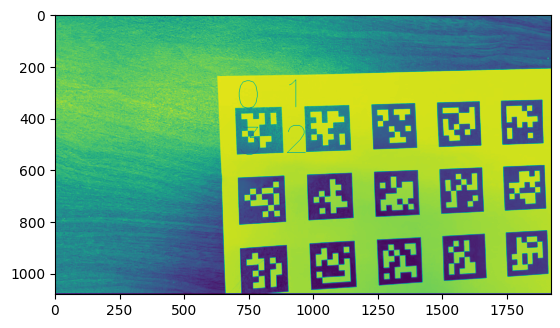

In [20]:
import cv2
import apriltag


detector = apriltag.Detector()
gray_image = cv2.cvtColor(vslam_images[0], cv2.COLOR_BGR2GRAY)
#gray_image = cv2.rotate(gray_image, cv2.ROTATE_90_CLOCKWISE)
#gray_image=cv2.flip(gray_image, 0)
detections = detector.detect(gray_image)
corners=[]
for detection in detections:
    if detection.tag_id == 0:  
        corners_ = detection.corners  
        for i, corner in enumerate(corners_):
            print(f"Corner {i} (u_i): {corner}")
            cv2.putText(gray_image,str(i),(int(corner[0]), int(corner[1])),0,5,(0,0,0))
            corners.append((int(corner[0]), int(corner[1])))
plt.imshow(gray_image)

In [21]:
print(gray_image.shape)

(1080, 1920)


In [22]:
!pip install gtsam

/usr/bin/pip:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import load_entry_point


In [23]:
import gtsam
#del graph
graph = gtsam.NonlinearFactorGraph()
initial_estimate = gtsam.Values()


K = gtsam.Cal3_S2(camera_matrix[0, 0], camera_matrix[1, 1], 0, camera_matrix[0, 2], camera_matrix[1, 2])
corner_points = [
    gtsam.Point3(-0.005, -.005, 0),  # Corner 0: lower-left
    gtsam.Point3(.005, -.005, 0),  # Corner 1: lower-right
    gtsam.Point3(.005, .005, 0),    # Corner 2: upper-right
    gtsam.Point3(-.005, .005, 0),    # Corner 3: upper-left
]

prior_pose_noise= gtsam.noiseModel.Isotropic.Sigma(6,0.2)
graph.add(gtsam.gtsam.PriorFactorPose3(gtsam.symbol('X', 0),gtsam.Pose3(),prior_pose_noise))
 
noise_model = gtsam.noiseModel.Constrained.All(3) 
#noise_model = gtsam.noiseModel.Isotropic.Sigma(3, 0.025)
for i, corner_point in enumerate(corner_points):
    graph.add(gtsam.PriorFactorPoint3(gtsam.symbol('L', i), corner_point, noise_model))
    initial_estimate.insert(gtsam.symbol('L', i), corner_point)
    
observed_points = corners
measurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 2.0)  # Example: 1-pixel std devmeasurement_noise = gtsam.noiseModel.Isotropic.Sigma(2, 2.0)  # 2-pixel std dev
##measurement_noise = gtsam.noiseModel.Robust.Create(
##    gtsam.noiseModel.mEstimator.Huber(1.0),  # Huber loss function for robustness
##    gtsam.noiseModel.Isotropic.Sigma(2, 5.0)  # Measurement noise (2 pixels std dev)
##)

# Add projection factors for each observed corner
for i, (u, v) in enumerate(observed_points):
    #print(i)
    uv_measurement = gtsam.Point2(u, v)
    factor = gtsam.GenericProjectionFactorCal3_S2(uv_measurement, measurement_noise, gtsam.symbol('X', 0), gtsam.symbol('L', i), K)
    graph.add(factor)
    
    initial_pose = gtsam.Pose3(
    gtsam.Rot3.Ypr(-0.0314, -0.0314, -0.0314),  # Initial rotation
    gtsam.Point3(-0.01 , -0.5 , -0.1)     # Initial translation
)
    
initial_estimate.insert(gtsam.symbol('X', 0), initial_pose)


In [24]:
#print(graph)
initial_error = graph.error(initial_estimate)
print("Graph Initial Error ",initial_error)

Graph Initial Error  23273714.631072138


In [25]:

optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate)
result = optimizer.optimize()
print(result.atPose3(gtsam.symbol('X', 0)))

R: [
	0.999164, -0.0362764, 0.0188584;
	0.0366256, 0.999158, -0.0185142;
	-0.0181709, 0.0191895, 0.999651
]
t: -0.0158933   0.028481 -0.0816415



In [26]:

print("Final Graph Error", graph.error(result))

Final Graph Error 0.34206135297270945


4
R: [
	0.999164, -0.0362764, 0.0188584;
	0.0366256, 0.999158, -0.0185142;
	-0.0181709, 0.0191895, 0.999651
]
t: -0.0158933   0.028481 -0.0816415

Reprojection Error  0.37327702692703085
R: [
	0.999164, -0.0362764, 0.0188584;
	0.0366256, 0.999158, -0.0185142;
	-0.0181709, 0.0191895, 0.999651
]
t: -0.0158933   0.028481 -0.0816415

Reprojection Error  0.47387826380569176
R: [
	0.999164, -0.0362764, 0.0188584;
	0.0366256, 0.999158, -0.0185142;
	-0.0181709, 0.0191895, 0.999651
]
t: -0.0158933   0.028481 -0.0816415

Reprojection Error  0.5499116927208131
R: [
	0.999164, -0.0362764, 0.0188584;
	0.0366256, 0.999158, -0.0185142;
	-0.0181709, 0.0191895, 0.999651
]
t: -0.0158933   0.028481 -0.0816415

Reprojection Error  0.46265115992755107


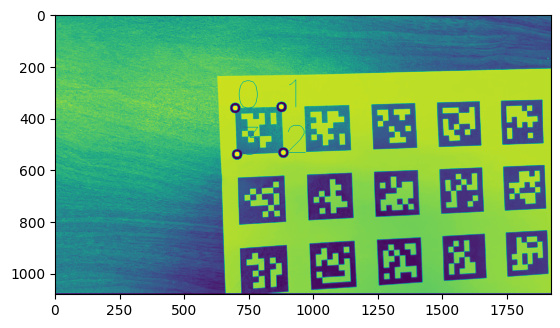

In [27]:
# Reprojection Verification 
total_error = 0.0
num_points = len(observed_points)
print(num_points)
for i, (u_obs, v_obs) in enumerate(observed_points):    
    corner_3D = result.atPoint3(gtsam.symbol('L', i))

    camera_pose = result.atPose3(gtsam.symbol('X', 0))  
    print(camera_pose)
    camera = gtsam.PinholeCameraCal3_S2(camera_pose, K)
    uv_reprojected = camera.project(corner_3D)
    
    gray_image=cv2.circle(gray_image, (u_obs,v_obs), 20, (0, 255, 0), -1)
    gray_image=cv2.circle(gray_image,(int(uv_reprojected[0]),int(uv_reprojected[1])),10,(255,255,255),-1)
    
    plt.imshow(gray_image)
    reprojection_error = np.sqrt((u_obs - uv_reprojected[0])**2 + (v_obs - uv_reprojected[1])**2)/np.sqrt(2)
    print("Reprojection Error ",reprojection_error)
    total_error += reprojection_error

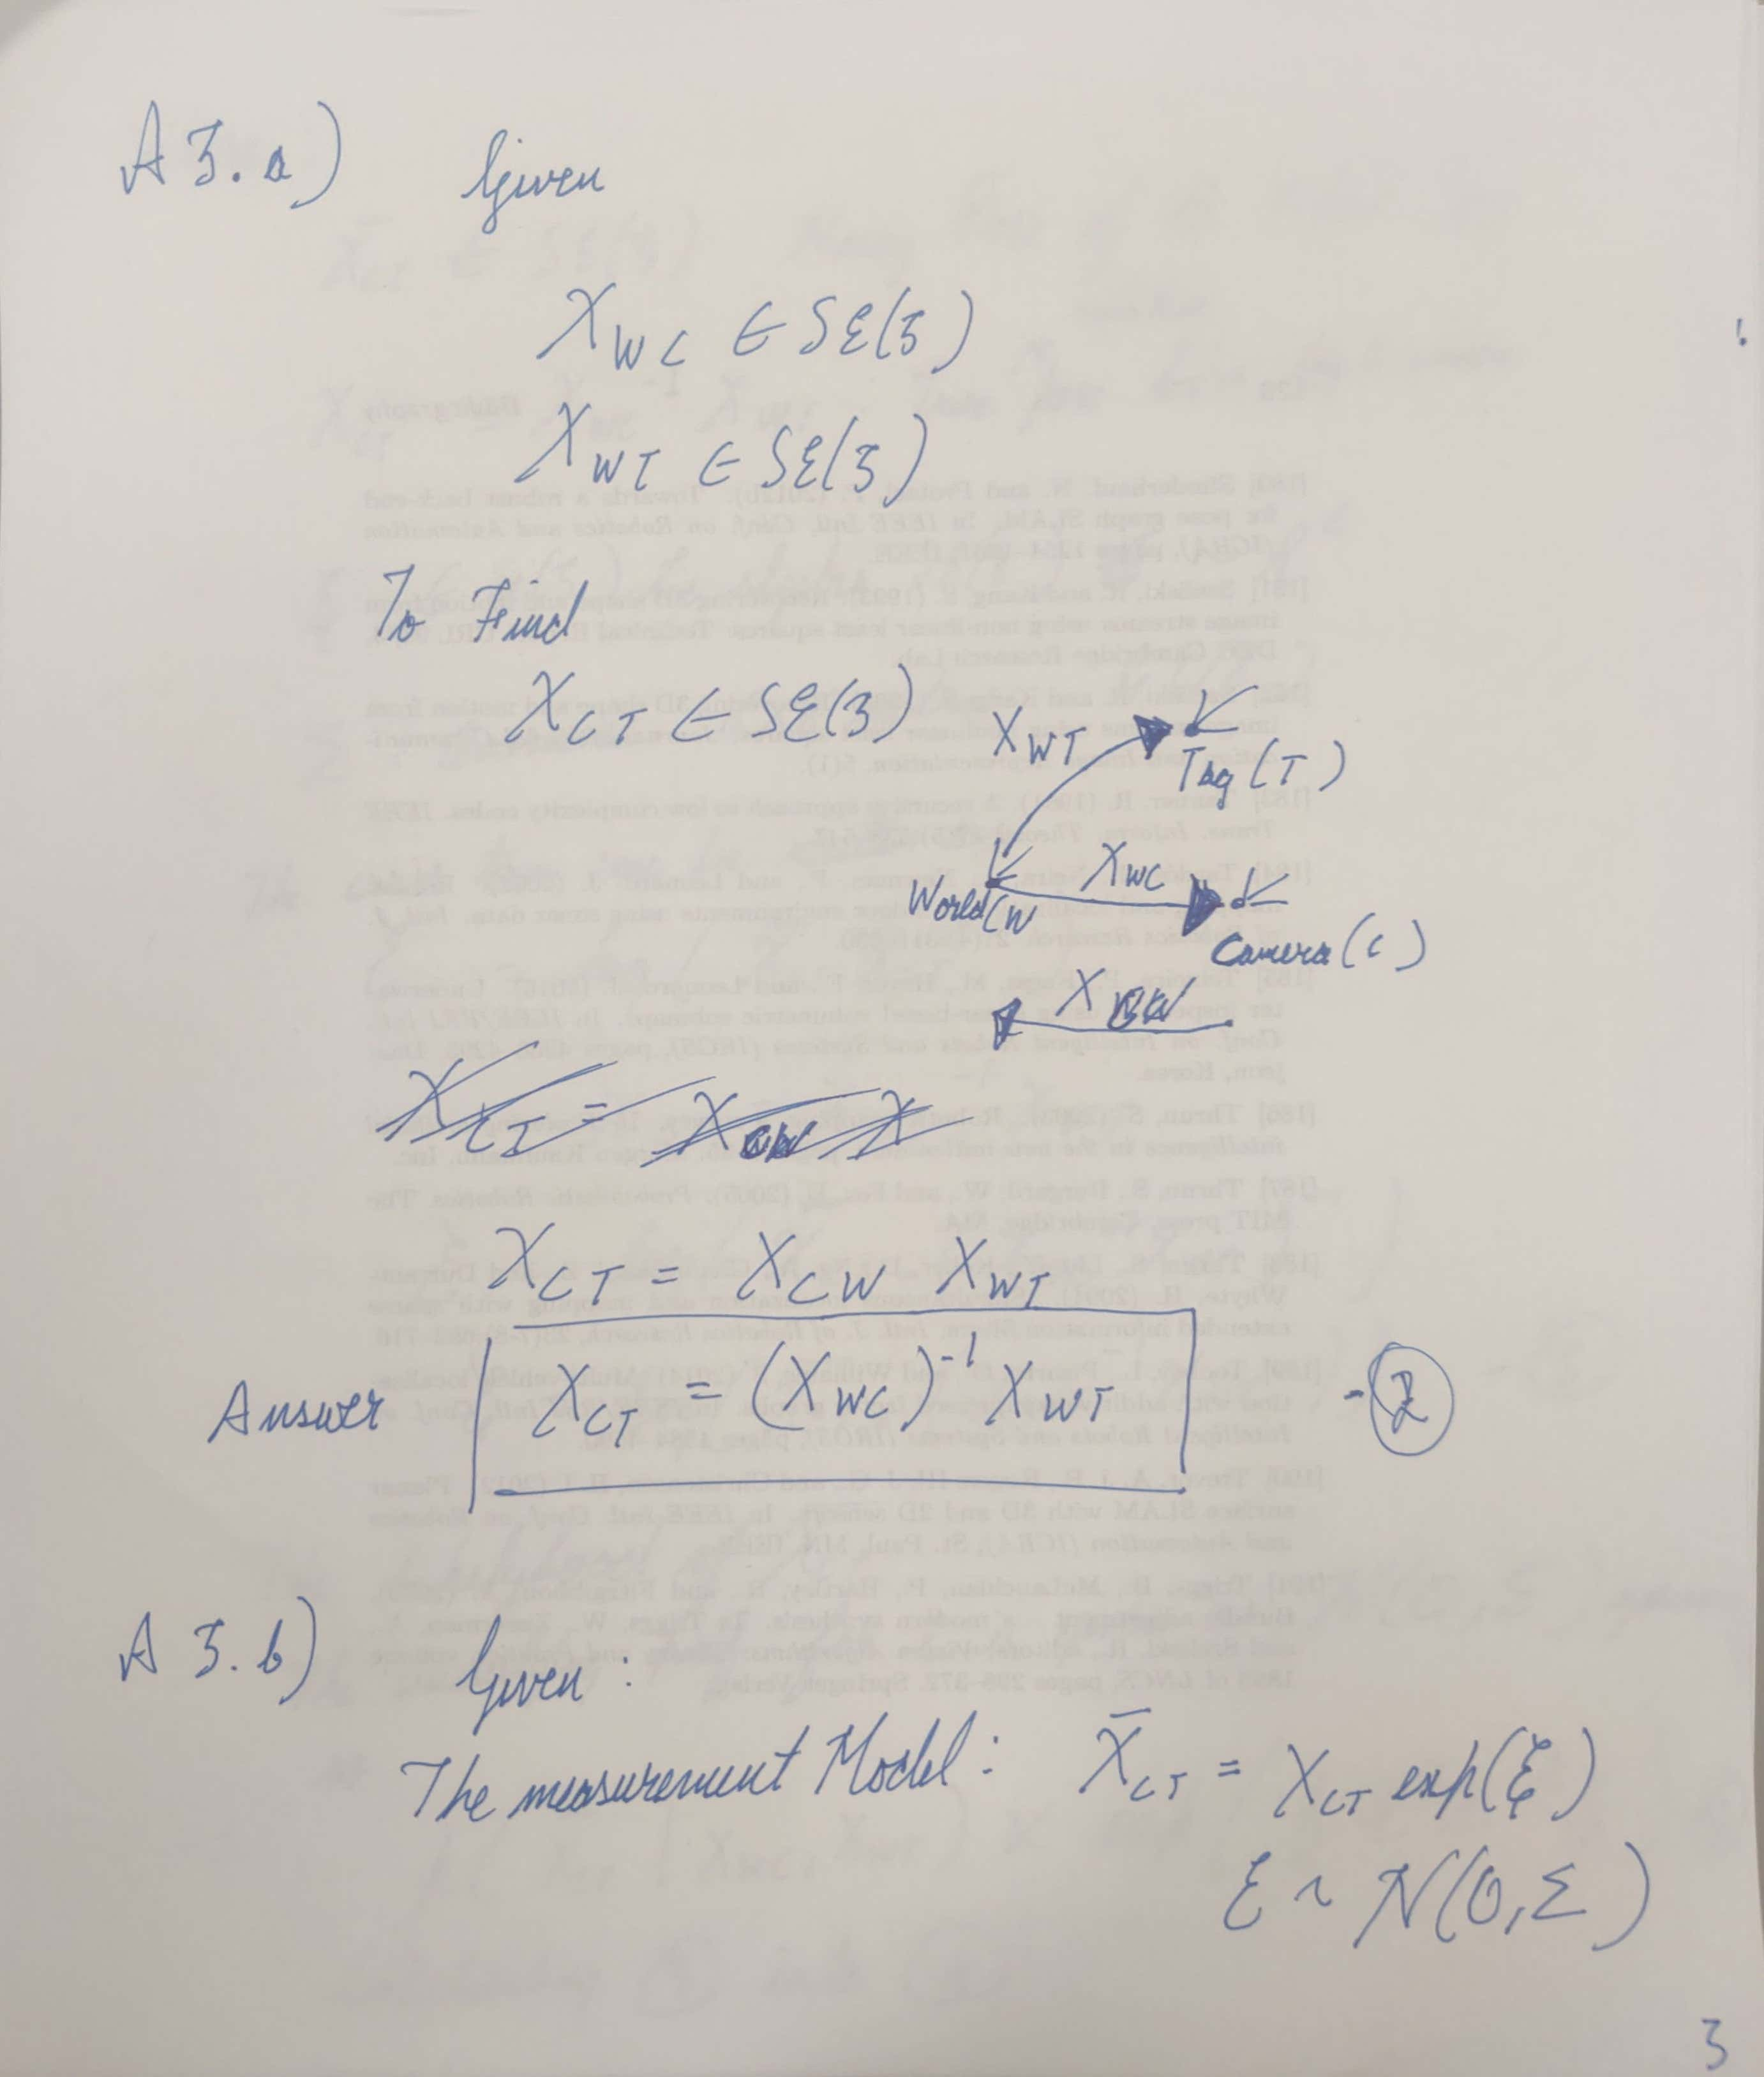

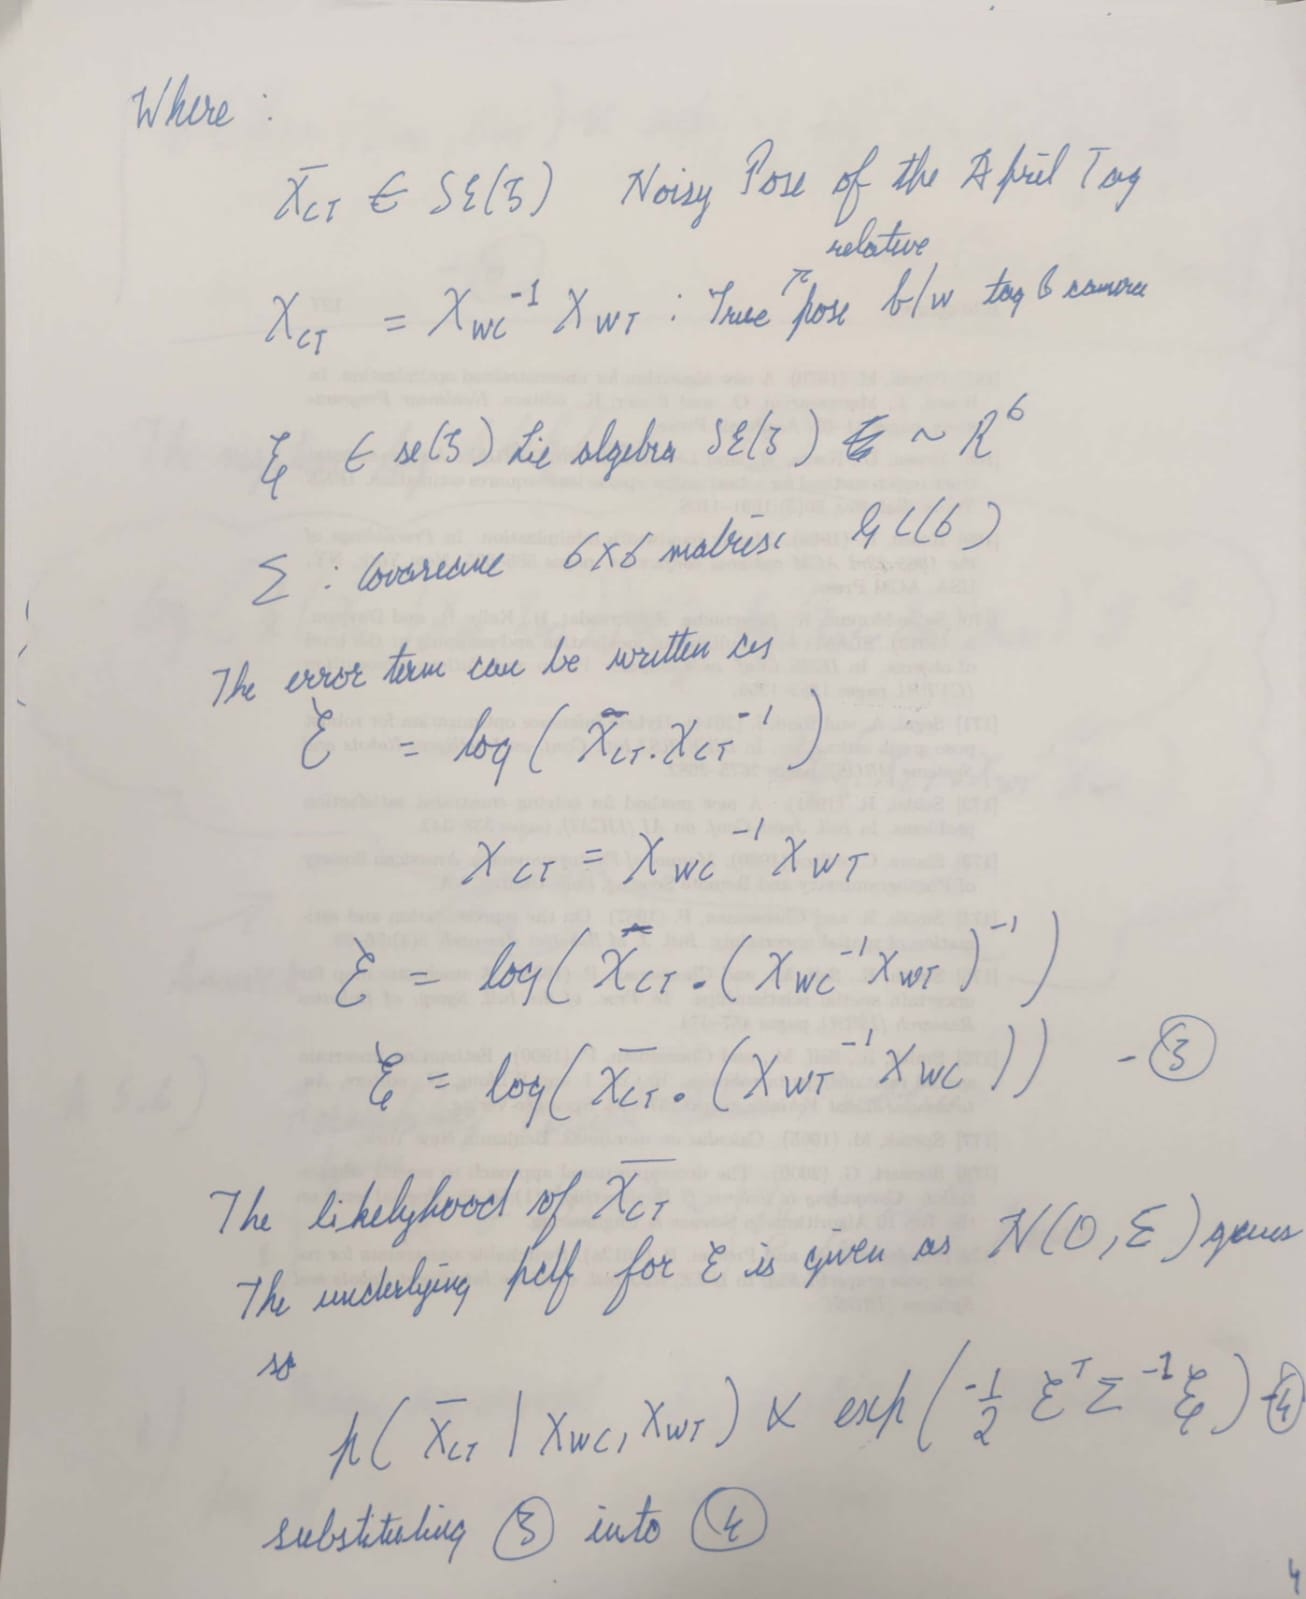

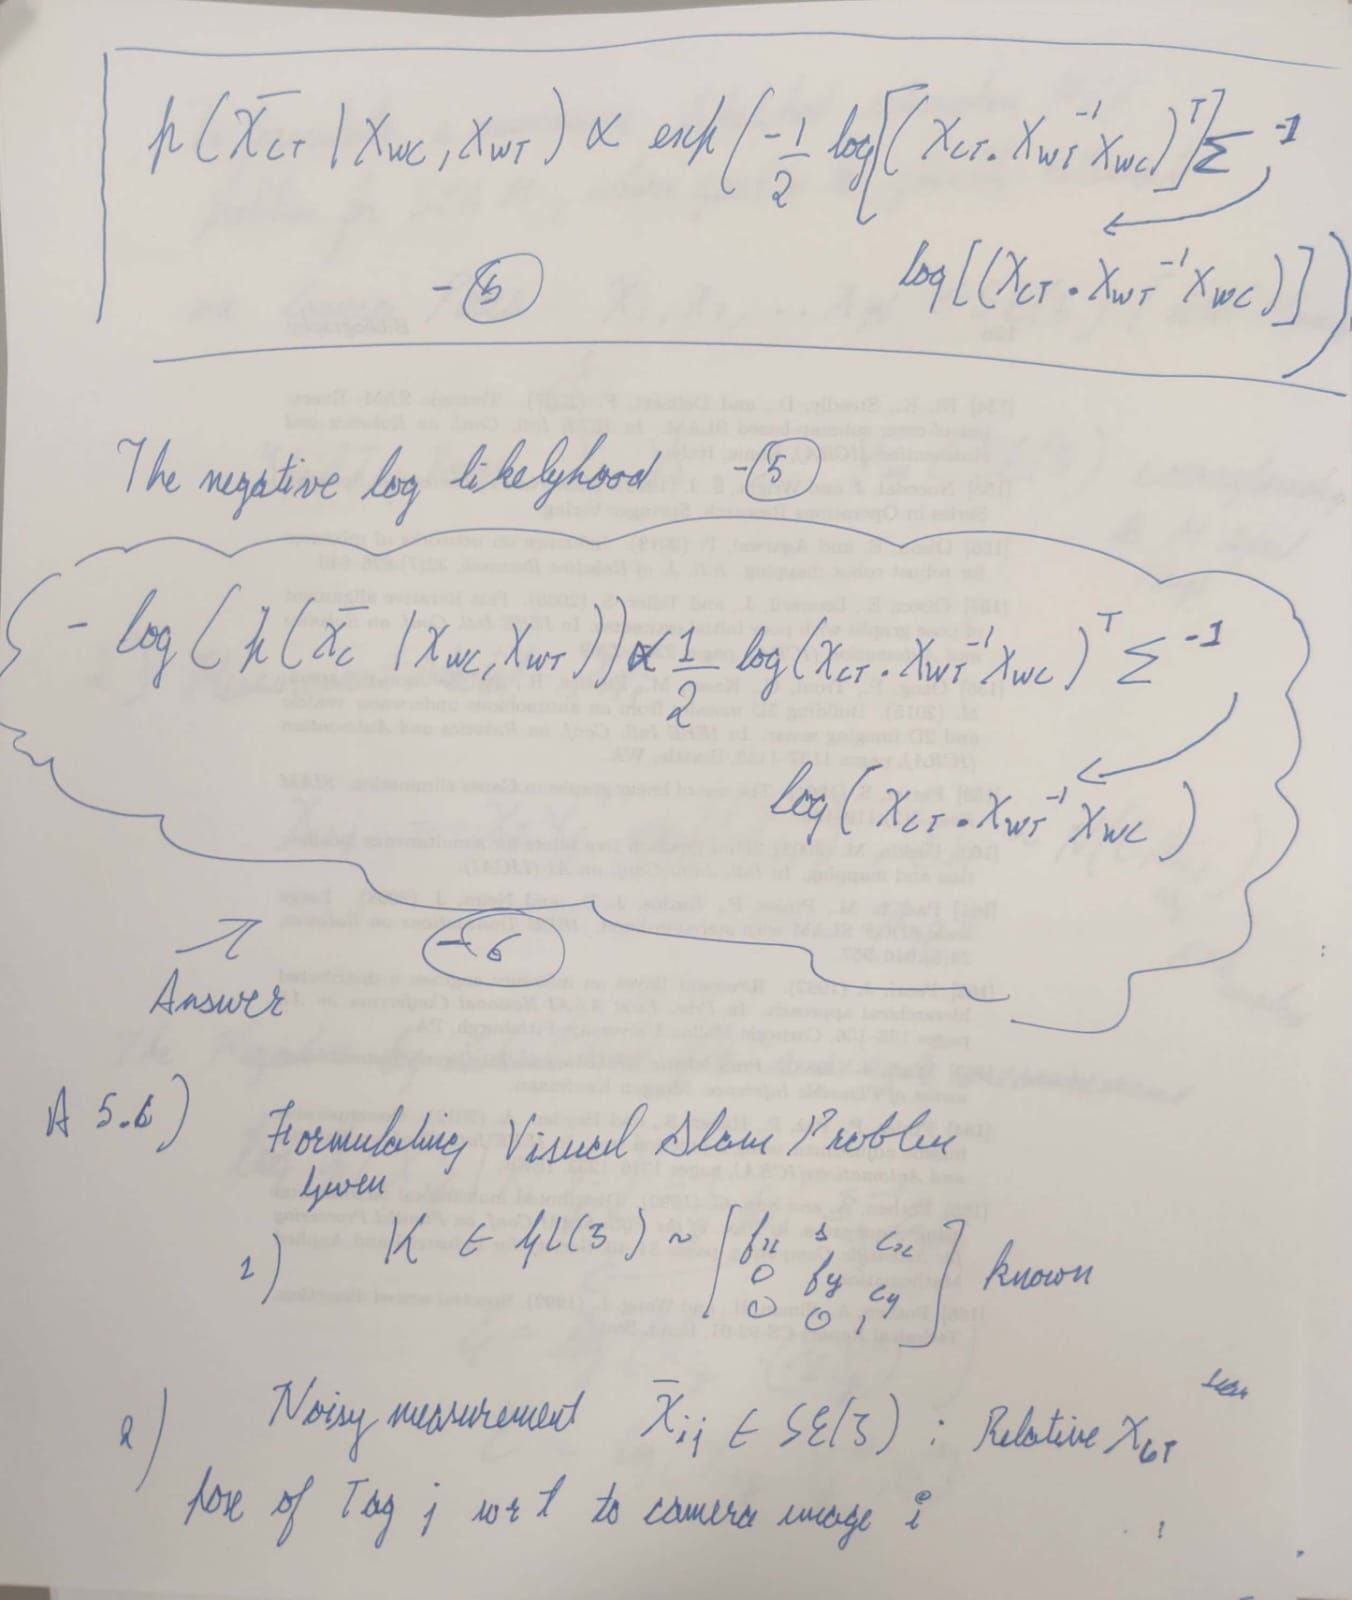

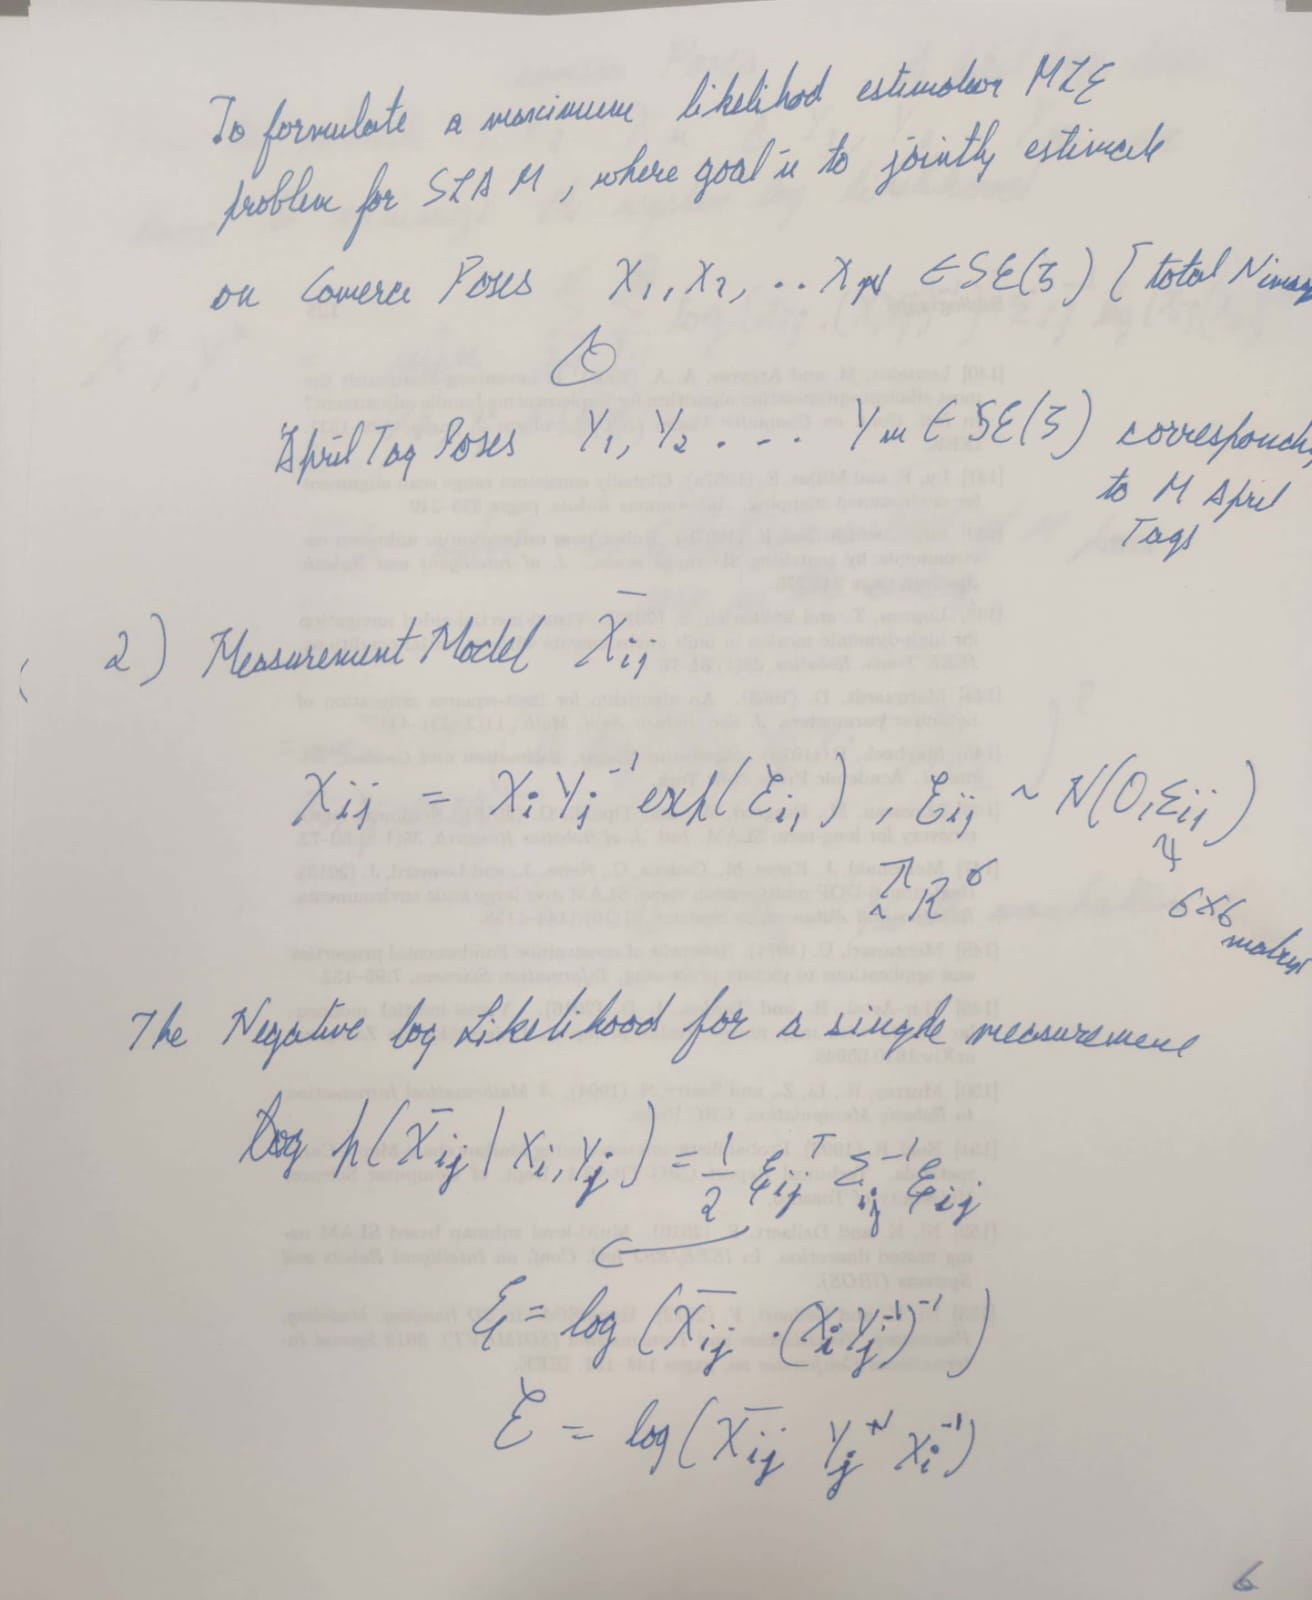

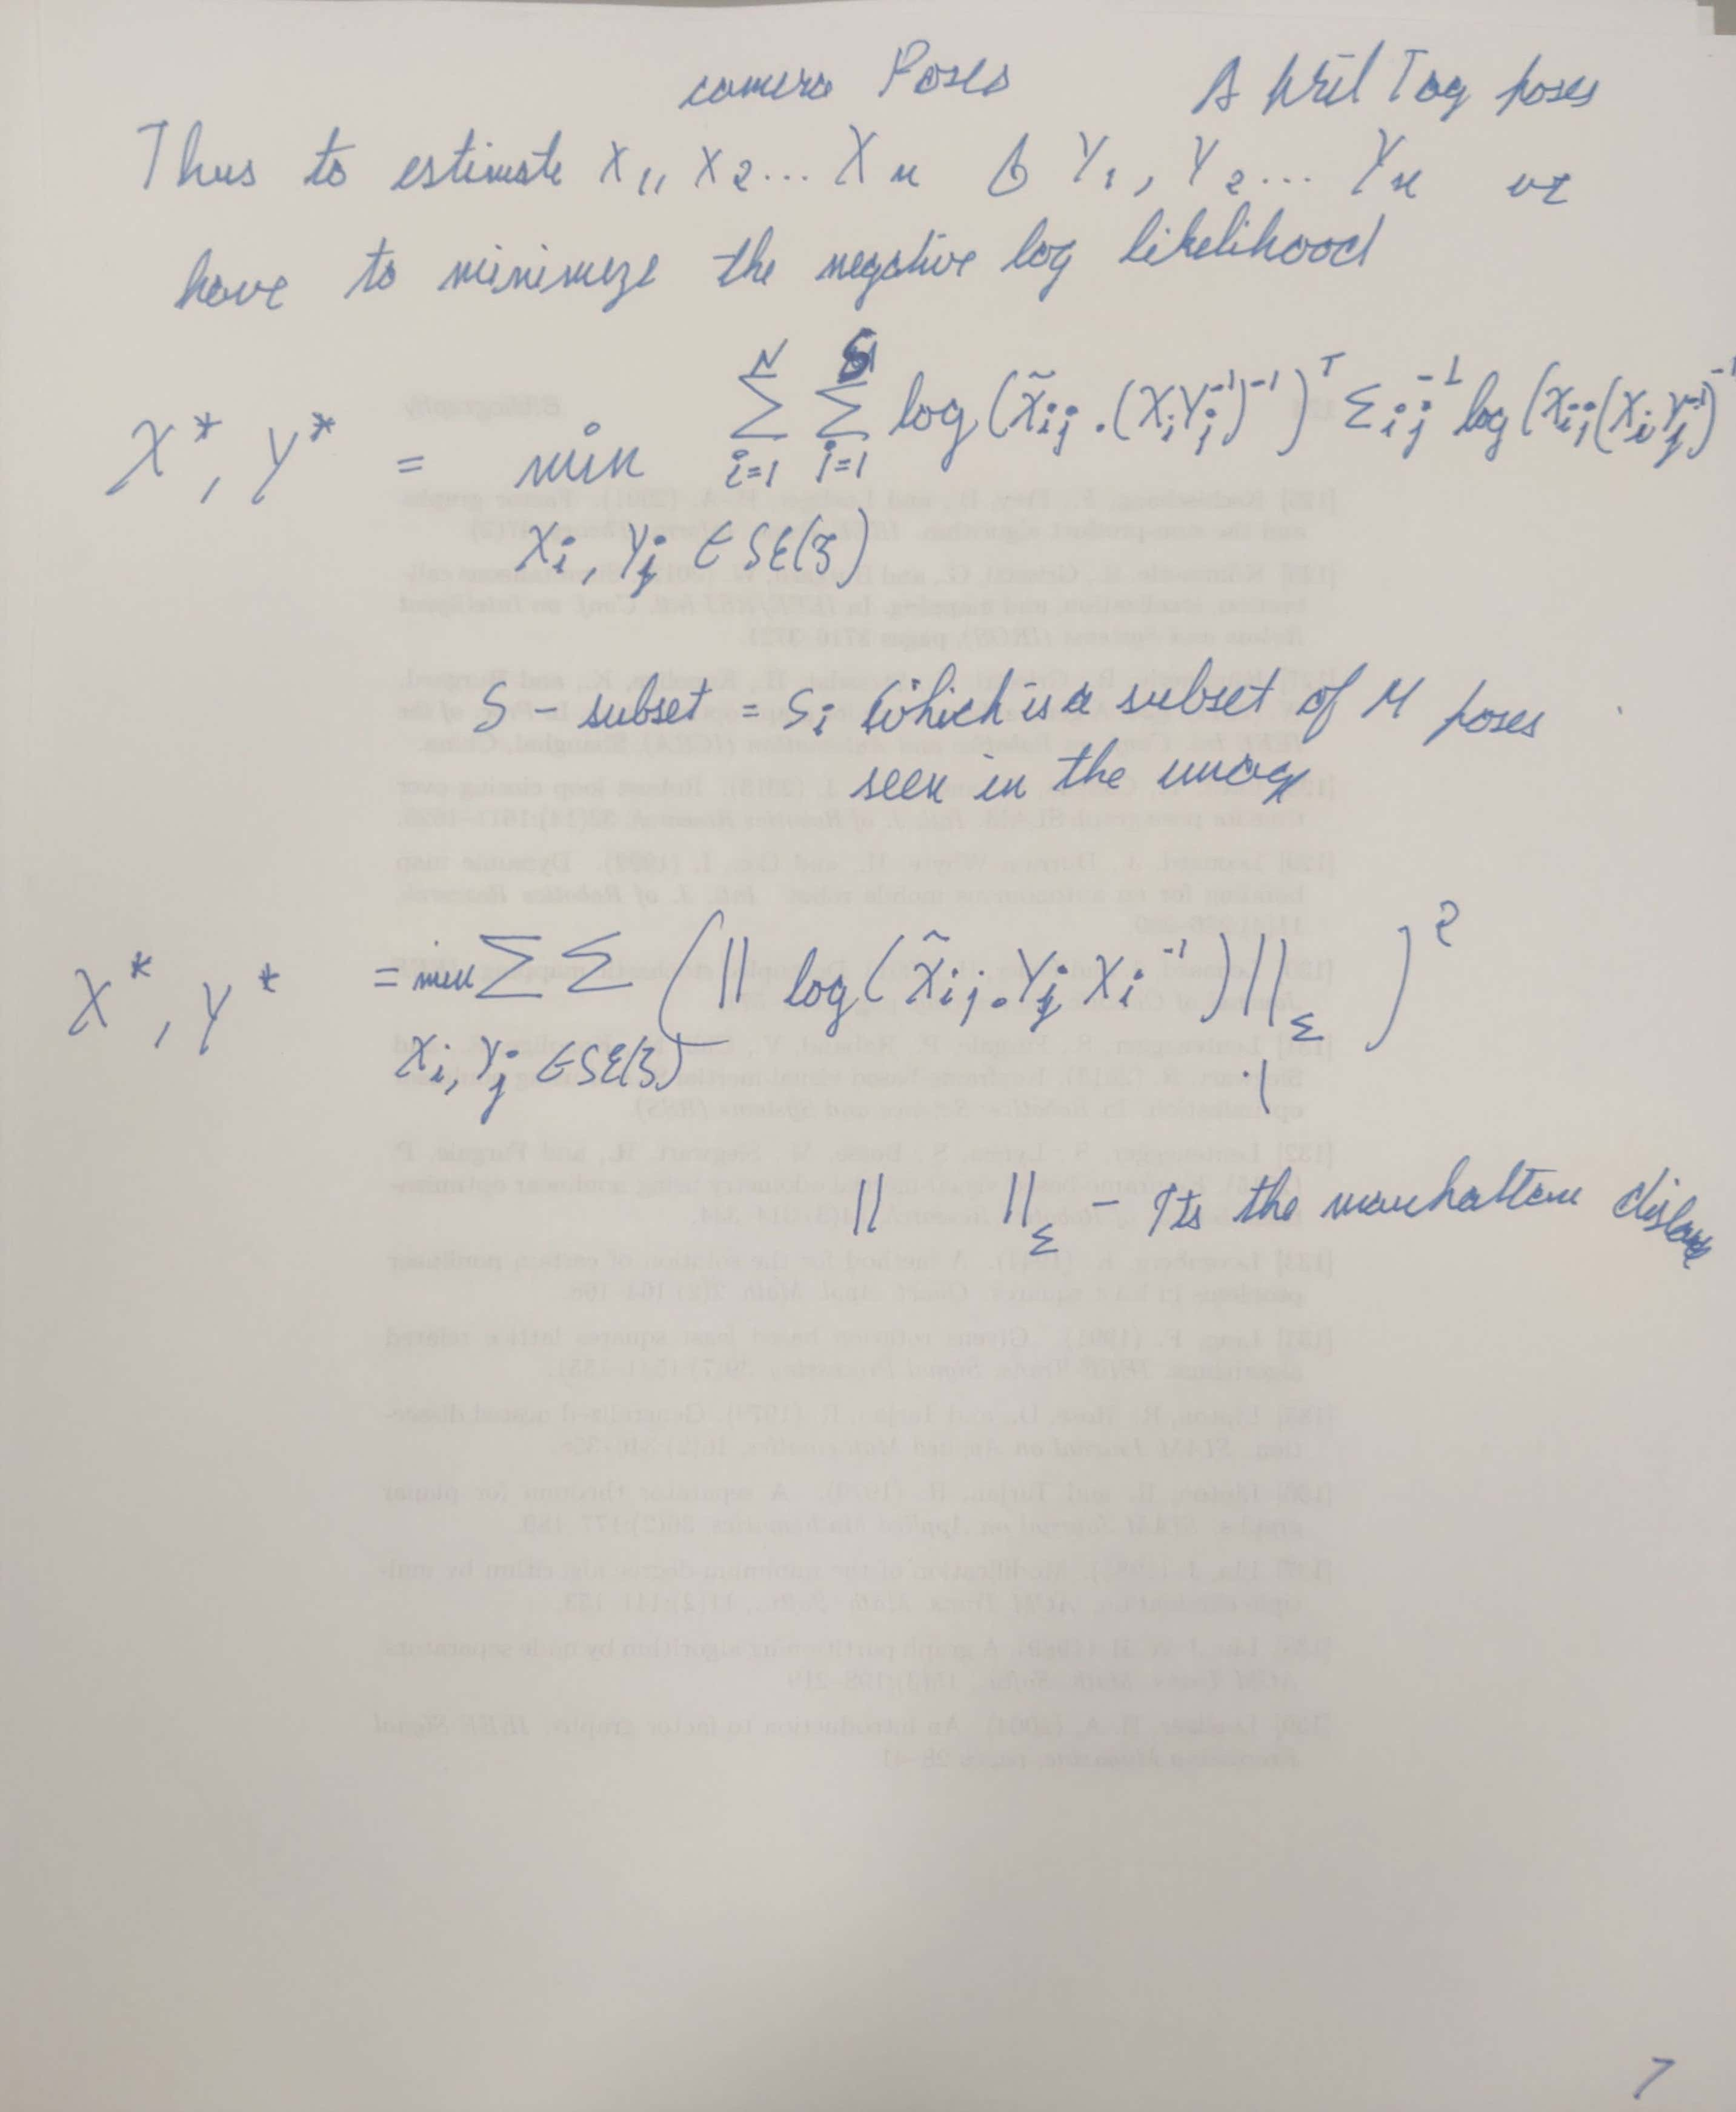

In [28]:
#Ques 3.d
img_folder="./vslam/"
img_list=[]
image_paths = sorted(glob.glob(os.path.join(img_folder, "*.jpg")), key=lambda x: os.path.basename(x).split('.')[0])
print("Image Paths: ", len(image_paths) ,image_paths[:10])
vslam_images = [cv2.imread(image_path) for image_path in image_paths]


Image Paths:  500 ['./vslam/frame_0.jpg', './vslam/frame_1.jpg', './vslam/frame_10.jpg', './vslam/frame_100.jpg', './vslam/frame_101.jpg', './vslam/frame_102.jpg', './vslam/frame_103.jpg', './vslam/frame_104.jpg', './vslam/frame_105.jpg', './vslam/frame_106.jpg']


In [29]:
tag_size = 0.01 
half_size = tag_size / 2
object_points = np.array([
    [-half_size, -half_size, 0],  # Bottom-left corner
    [ half_size, -half_size, 0],  # Bottom-right corner
    [ half_size,  half_size, 0],  # Top-right corner
    [-half_size,  half_size, 0]   # Top-left corner
], dtype=np.float32)



In [30]:
h,w=vslam_images[0].shape[:2]

In [31]:
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w,h), 1, (w,h))
new_dist_coeffs=np.array([0.0,0.0,0.0,0.0,0.0])


In [32]:
print(dist_coeffs)

[[ 0.23638885 -1.01460061 -0.00328882  0.0055401   1.52685586]]


In [33]:
observations=[]

detector = apriltag.Detector()
for image_id in range(len(vslam_images)):
    img=vslam_images[image_id]
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.undistort(gray_image, camera_matrix, dist_coeffs)
    #gray_image = cv2.undistort(gray_image, camera_matrix, dist_coeffs, None, newcameramtx)
    
    detections = detector.detect(gray_image)
    corners=[]
    
    for detection in detections:
        corners = detection.corners  # 2D points of the tag corners in the image
        success, rvec, tvec = cv2.solvePnP(object_points, corners, camera_matrix, dist_coeffs)
        #success, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, corners, newcameramtx, new_dist_coeffs,
    #iterationsCount=1000, reprojectionError=0.1, confidence=0.99, flags=cv2.SOLVEPNP_AP3P)
        if success:
            tag_id = detection.tag_id
            translation = tvec
            rotation_matrix, _ = cv2.Rodrigues(rvec)
            gtsam_rotation = gtsam.Rot3(rotation_matrix)
            gtsam_translation = gtsam.Point3(*tvec.flatten())
            pose = gtsam.Pose3(gtsam_rotation, gtsam_translation)

            observations.append({
                'image': image_id,
                'tag': tag_id,
                'measured': pose
            })
        else:
            print("Issue with Image {} Marker {}".format(image_id,tag_id))

    

/tmp/pip-install-49q0y2cn/apriltag/core/contrib/apriltag_quad_contour.c:467: warning: count < 8 :(
/tmp/pip-install-49q0y2cn/apriltag/core/contrib/apriltag_quad_contour.c:467: warning: count < 8 :(
/tmp/pip-install-49q0y2cn/apriltag/core/contrib/apriltag_quad_contour.c:467: warning: count < 8 :(
/tmp/pip-install-49q0y2cn/apriltag/core/contrib/apriltag_quad_contour.c:467: warning: count < 8 :(
/tmp/pip-install-49q0y2cn/apriltag/core/contrib/apriltag_quad_contour.c:467: warning: count < 8 :(
/tmp/pip-install-49q0y2cn/apriltag/core/contrib/apriltag_quad_contour.c:467: warning: count < 8 :(
/tmp/pip-install-49q0y2cn/apriltag/core/contrib/apriltag_quad_contour.c:467: warning: count < 8 :(
/tmp/pip-install-49q0y2cn/apriltag/core/contrib/apriltag_quad_contour.c:467: warning: count < 8 :(
/tmp/pip-install-49q0y2cn/apriltag/core/contrib/apriltag_quad_contour.c:467: warning: count < 8 :(
/tmp/pip-install-49q0y2cn/apriltag/core/contrib/apriltag_quad_contour.c:467: warning: count < 8 :(


In [34]:
#print(observations[:10]) 

In [41]:
import gtsam
from gtsam import symbol ,Pose3 ,Point3 ,noiseModel

# Define constant
N = 0
M = 0
Sigma = gtsam.noiseModel.Isotropic.Sigma(6, 10.0)

graph = gtsam.NonlinearFactorGraph()
initial_estimates = gtsam.Values()

initial_camera_pose = Pose3()
graph.add(gtsam.PriorFactorPose3(symbol('x', 0), initial_camera_pose, noiseModel.Constrained.All(6)))
initial_estimates.insert(symbol('x', 0), initial_camera_pose)

for obs in observations:
    
    i = obs['image']  
    j = obs['tag']    
 
    measured_pose = obs['measured'] 
  
    
    if not initial_estimates.exists(symbol('x',i)): 
        camera_pose = gtsam.Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0.0, 0, 0)) 
        initial_estimates.insert(symbol('x', i), camera_pose)
        N=max(N,i)
    
    if not initial_estimates.exists(symbol('y',j)):
        tag_pose = gtsam.Pose3(gtsam.Rot3.Ypr(0, 0, 0), gtsam.Point3(0, 0.00, 0)) 
        initial_estimates.insert(symbol('y', j), tag_pose)
        M=max(j,M)
    
    
    factor = gtsam.BetweenFactorPose3(
        symbol('x', i),  
        symbol('y', j),  
        
        measured_pose,   
        Sigma           
    )
    graph.add(factor)

#optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimates)

In [36]:
#print(graph)

In [37]:
print(N,M)

499 23


In [42]:
# Optimize

params =  gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimates, params)
result = optimizer.optimize()
# Print results
#print("\nOptimized Camera Poses:")
#for i in range(N):
#    print(f"Camera {i}: {result.atPose3(symbol('x', i))}")

#print("\nOptimized AprilTag Poses:")
#for j in range(M):
#    print(f"AprilTag {j}: {result.atPose3(symbol('y', j))}")

In [39]:
%matplotlib notebook

In [40]:
print(f"Optimization Error: {optimizer.error()}")

Optimization Error: 0.27213715355273466


In [54]:
print(N,M)

499 23


In [45]:
camera_poses = []
tag_poses = []

N=499
M=23



for i in range(N):
    camera_key = gtsam.symbol('x', i)
    if result.exists(camera_key):
        pose = result.atPose3(camera_key)
        camera_poses.append(pose.translation())

for j in range(M):
    tag_key = gtsam.symbol('y', j)
    if result.exists(tag_key):
        pose = result.atPose3(tag_key)
        tag_poses.append(pose.translation())

# Plot results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

camera_poses = np.array(camera_poses)
tag_poses = np.array(tag_poses)

ax.scatter(camera_poses[:, 0], camera_poses[:, 1], camera_poses[:, 2], c='b', marker='o', label='Camera Poses')
ax.scatter(tag_poses[:, 0], tag_poses[:, 1], tag_poses[:, 2], c='r', marker='^', label='AprilTags')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()


plt.title('Visual SLAM Results')
plt.show()

In [46]:


plt.title('Visual SLAM Results')
plt.show()

In [51]:
camera_poses = []
tag_poses = []

N=499
M=23



for i in range(N):
    camera_key = gtsam.symbol('x', i)
    if result.exists(camera_key):
        pose = result.atPose3(camera_key)
        camera_poses.append(pose.translation())

for j in range(M):
    tag_key = gtsam.symbol('y', j)
    if result.exists(tag_key):
        pose = result.atPose3(tag_key)
        tag_poses.append(pose.translation())

# Plot results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

camera_poses = np.array(camera_poses)
tag_poses = np.array(tag_poses)

ax.scatter(camera_poses[:, 0], camera_poses[:, 1], camera_poses[:, 2], c='b', marker='o', label='Camera Poses')
ax.scatter(tag_poses[:, 0], tag_poses[:, 1], tag_poses[:, 2], c='r', marker='^', label='AprilTags')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.title('Visual SLAM Results')
plt.show()

<IPython.core.display.Javascript object>

In [43]:
print(f"Optimization Error: {optimizer.error()}")

Optimization Error: 0.2721371535741651
